# Kalman Filter Python Exercises: From Single-Variable Filtering to Sensor Fusion

In [13]:
# Import core modules (ensure inline figures)
import os
import sys

workspace_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if workspace_root not in sys.path:
    sys.path.insert(0, workspace_root)
print("Using workspace root:", workspace_root)

import matplotlib
matplotlib.use("module://matplotlib_inline.backend_inline")  # force inline backend
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import stats
import numpy as np

# Use a single widely available font to avoid missing-font warnings
rcParams['font.family'] = ['DejaVu Sans']
rcParams['axes.unicode_minus'] = False

from core.bayesfilter import SimpleKalmanFilter, MultiSensorKalmanFilter


Using workspace root: /Users/songfei/Study/gitclone/searching_exercise


Example 1: Removing zero-mean Gaussian noise
Problem setup:

- Assume the true signal is constant: $x = 10$
- Observed noisy signal: $z = 10 + v$, $v \sim \mathcal{N}(0, 4)$

Goal: estimate the true value from noisy observations

Example 1: Filter Gaussian noise
True value: 10.0
Measurement MSE: 3.6206
Filtered MSE: 0.2047
Improvement: 94.3%
Final Kalman gain: 0.0198
Final uncertainty: 0.0794


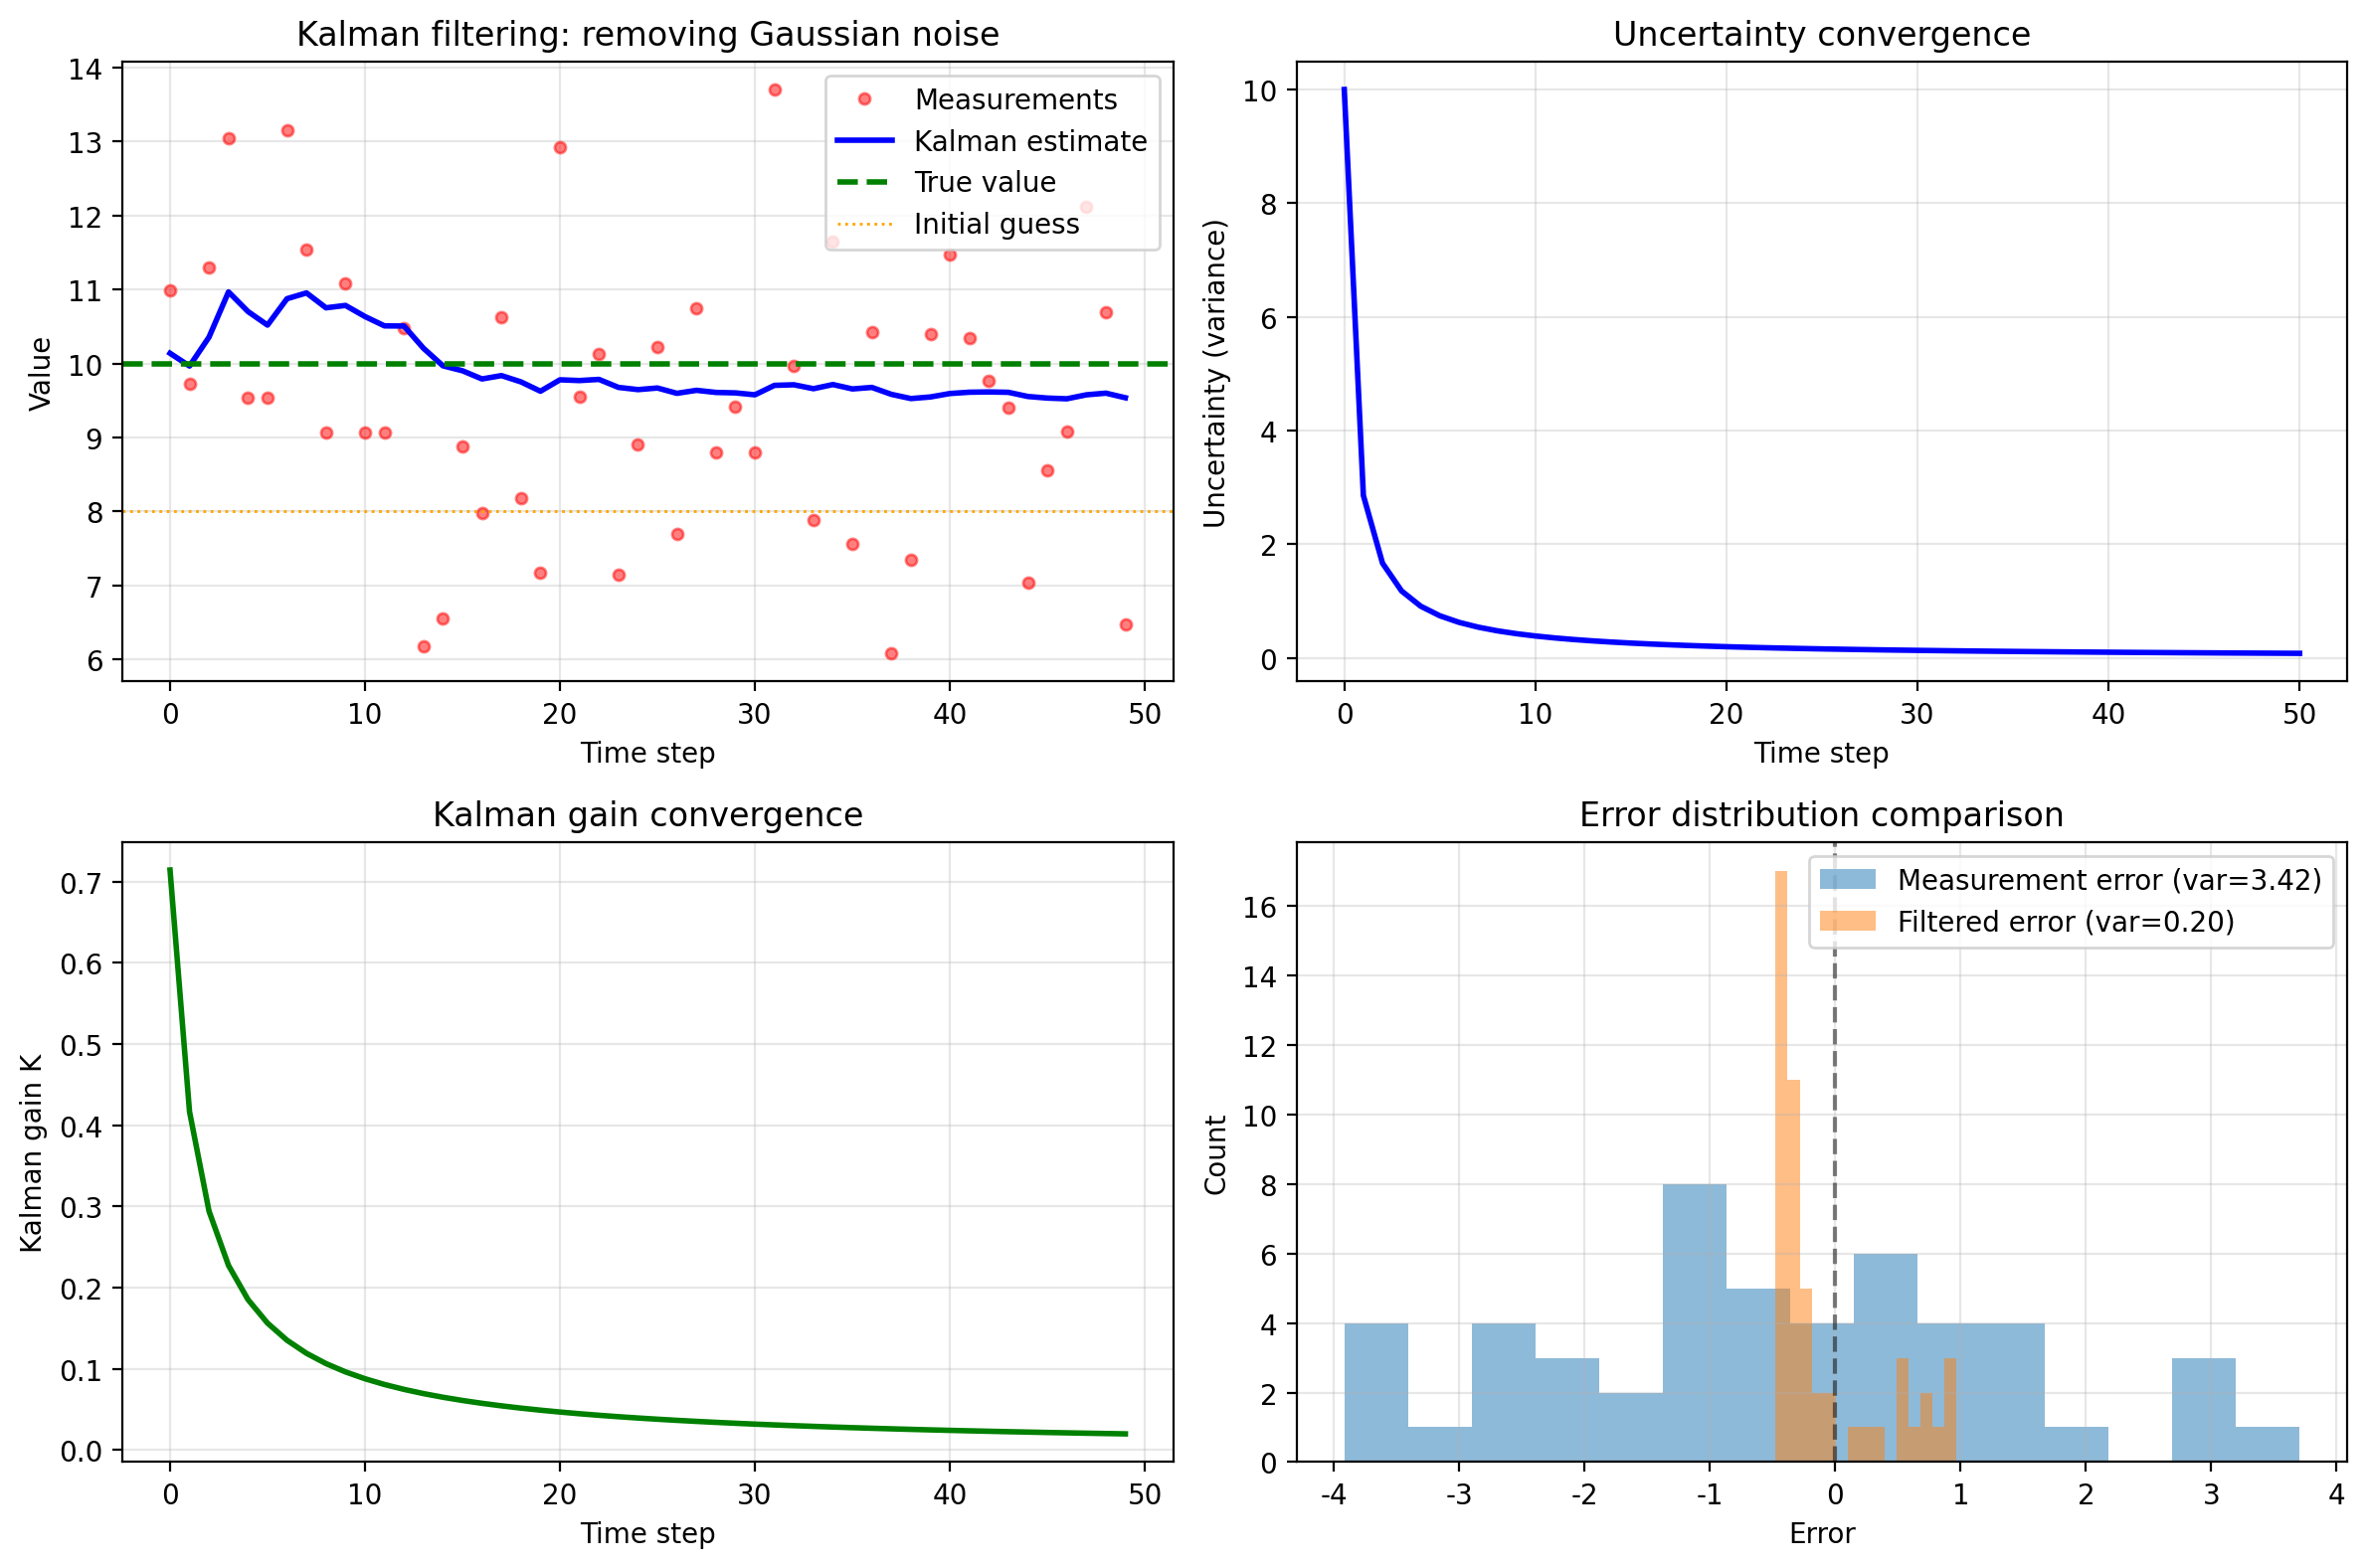


Convergence sample:
step | measurement | estimate | K | uncertainty
------------------------------------------------------------
     0 |  10.993 |    10.138 |     0.7143 |     2.8571
     1 |   9.723 |     9.965 |     0.4167 |     1.6667
     2 |  11.295 |    10.357 |     0.2941 |     1.1765
     3 |  13.046 |    10.968 |     0.2273 |     0.9091
     4 |   9.532 |    10.702 |     0.1852 |     0.7407
     5 |   9.532 |    10.519 |     0.1562 |     0.6250
     6 |  13.158 |    10.876 |     0.1351 |     0.5405
     7 |  11.535 |    10.954 |     0.1190 |     0.4762
     8 |   9.061 |    10.753 |     0.1064 |     0.4255
     9 |  11.085 |    10.785 |     0.0962 |     0.3846

Steady-state analysis:
Final Kalman gain: 0.019841
Theoretical steady-state gain (analytic): 0.002494


In [14]:
def example1_filter_constant_signal():
    """Example 1: filter Gaussian noise to estimate a constant signal"""
    np.random.seed(42)
    
    # Parameter setup
    true_value = 10.0
    measurement_noise_variance = 4.0  # R = 4
    n_measurements = 50
    
    # Generate noisy observations
    measurements = true_value + np.random.randn(n_measurements) * np.sqrt(measurement_noise_variance)
    
    # Build Kalman filter
    # Initial guess (intentionally rough)
    initial_guess = 8.0
    initial_uncertainty = 10.0  # Large initial uncertainty
    process_variance = 0.01  # Small Q because we assume the true value is almost fixed
    
    kf = SimpleKalmanFilter(
        initial_state=initial_guess,
        initial_uncertainty=initial_uncertainty,
        process_variance=process_variance,
        measurement_variance=measurement_noise_variance
    )
    
    # Filtering
    filtered_states, kalman_gains = kf.filter(measurements)
    
    # Compute performance metrics
    measurements_mse = np.mean((measurements - true_value)**2)
    filtered_mse = np.mean((filtered_states - true_value)**2)
    
    print("=" * 50)
    print("Example 1: Filter Gaussian noise")
    print("=" * 50)
    print(f"True value: {true_value}")
    print(f"Measurement MSE: {measurements_mse:.4f}")
    print(f"Filtered MSE: {filtered_mse:.4f}")
    print(f"Improvement: {(measurements_mse - filtered_mse)/measurements_mse*100:.1f}%")
    print(f"Final Kalman gain: {kalman_gains[-1]:.4f}")
    print(f"Final uncertainty: {kf.uncertainties[-1]:.4f}")
    
    # Visualization
    plt.figure(figsize=(12, 8))
    
    # Subplot 1: signal and estimate
    plt.subplot(2, 2, 1)
    time_steps = np.arange(n_measurements)
    plt.plot(time_steps, measurements, 'ro', alpha=0.5, label='Measurements', markersize=4)
    plt.plot(time_steps, filtered_states, 'b-', linewidth=2, label='Kalman estimate')
    plt.axhline(y=true_value, color='g', linestyle='--', linewidth=2, label='True value')
    plt.axhline(y=initial_guess, color='orange', linestyle=':', linewidth=1, label='Initial guess')
    plt.xlabel('Time step')
    plt.ylabel('Value')
    plt.title('Kalman filtering: removing Gaussian noise')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Subplot 2: uncertainty trend
    plt.subplot(2, 2, 2)
    plt.plot(range(len(kf.uncertainties)), kf.uncertainties, 'b-', linewidth=2)
    plt.xlabel('Time step')
    plt.ylabel('Uncertainty (variance)')
    plt.title('Uncertainty convergence')
    plt.grid(True, alpha=0.3)
    
    # Subplot 3: Kalman gain trend
    plt.subplot(2, 2, 3)
    plt.plot(time_steps, kalman_gains, 'g-', linewidth=2)
    plt.xlabel('Time step')
    plt.ylabel('Kalman gain K')
    plt.title('Kalman gain convergence')
    plt.grid(True, alpha=0.3)
    
    # Subplot 4: error distribution
    plt.subplot(2, 2, 4)
    measurement_errors = measurements - true_value
    filtered_errors = filtered_states - true_value
    
    plt.hist(measurement_errors, bins=15, alpha=0.5, label=f'Measurement error (var={np.var(measurement_errors):.2f})')
    plt.hist(filtered_errors, bins=15, alpha=0.5, label=f'Filtered error (var={np.var(filtered_errors):.2f})')
    plt.axvline(x=0, color='k', linestyle='--', alpha=0.5)
    plt.xlabel('Error')
    plt.ylabel('Count')
    plt.title('Error distribution comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print convergence sample
    print("\nConvergence sample:")
    print("step | measurement | estimate | K | uncertainty")
    print("-" * 60)
    for i in range(min(10, n_measurements)):
        print(f"{i:6d} | {measurements[i]:7.3f} | {filtered_states[i]:9.3f} | {kalman_gains[i]:10.4f} | {kf.uncertainties[i+1]:10.4f}")
    
    # Steady-state analysis
    print(f"\nSteady-state analysis:")
    print(f"Final Kalman gain: {kalman_gains[-1]:.6f}")
    print(f"Theoretical steady-state gain (analytic): {process_variance/(process_variance + measurement_noise_variance):.6f}")
    
    return measurements, filtered_states, kalman_gains

measurements1, filtered1, gains1 = example1_filter_constant_signal()


---

Example 2: Sensor fusion (combining two noisy sensors)
Problem setup:
- True signal: $x(t) = t^2$
- Two sensors:

    - Sensor A: $y_a(t) = x(t) + v_a$, $v_a \sim \mathcal{N}(0, \sigma_a^2)$

    - Sensor B: $y_b(t) = x(t) + v_b$, $v_b \sim \mathcal{N}(0, \sigma_b^2)$

Key insight: treat the two sensors as a "virtual sensor" whose observation noise is the harmonic mean of the two.

Example 2: Sensor fusion (true signal: x(t) = t^2)
Sensor A noise std: 5.0, variance: 25.0
Sensor B noise std: 1.0, variance: 1.0

MSE comparison:
  Sensor A only: 20.6827
  Sensor B only: 0.9009
  Weighted average: 0.8194 (weights: A=0.038, B=0.962)
  Kalman fusion: 0.3349

Improvement vs sensor A: 98.4%
Improvement vs sensor B: 62.8%
Improvement vs weighted average: 59.1%


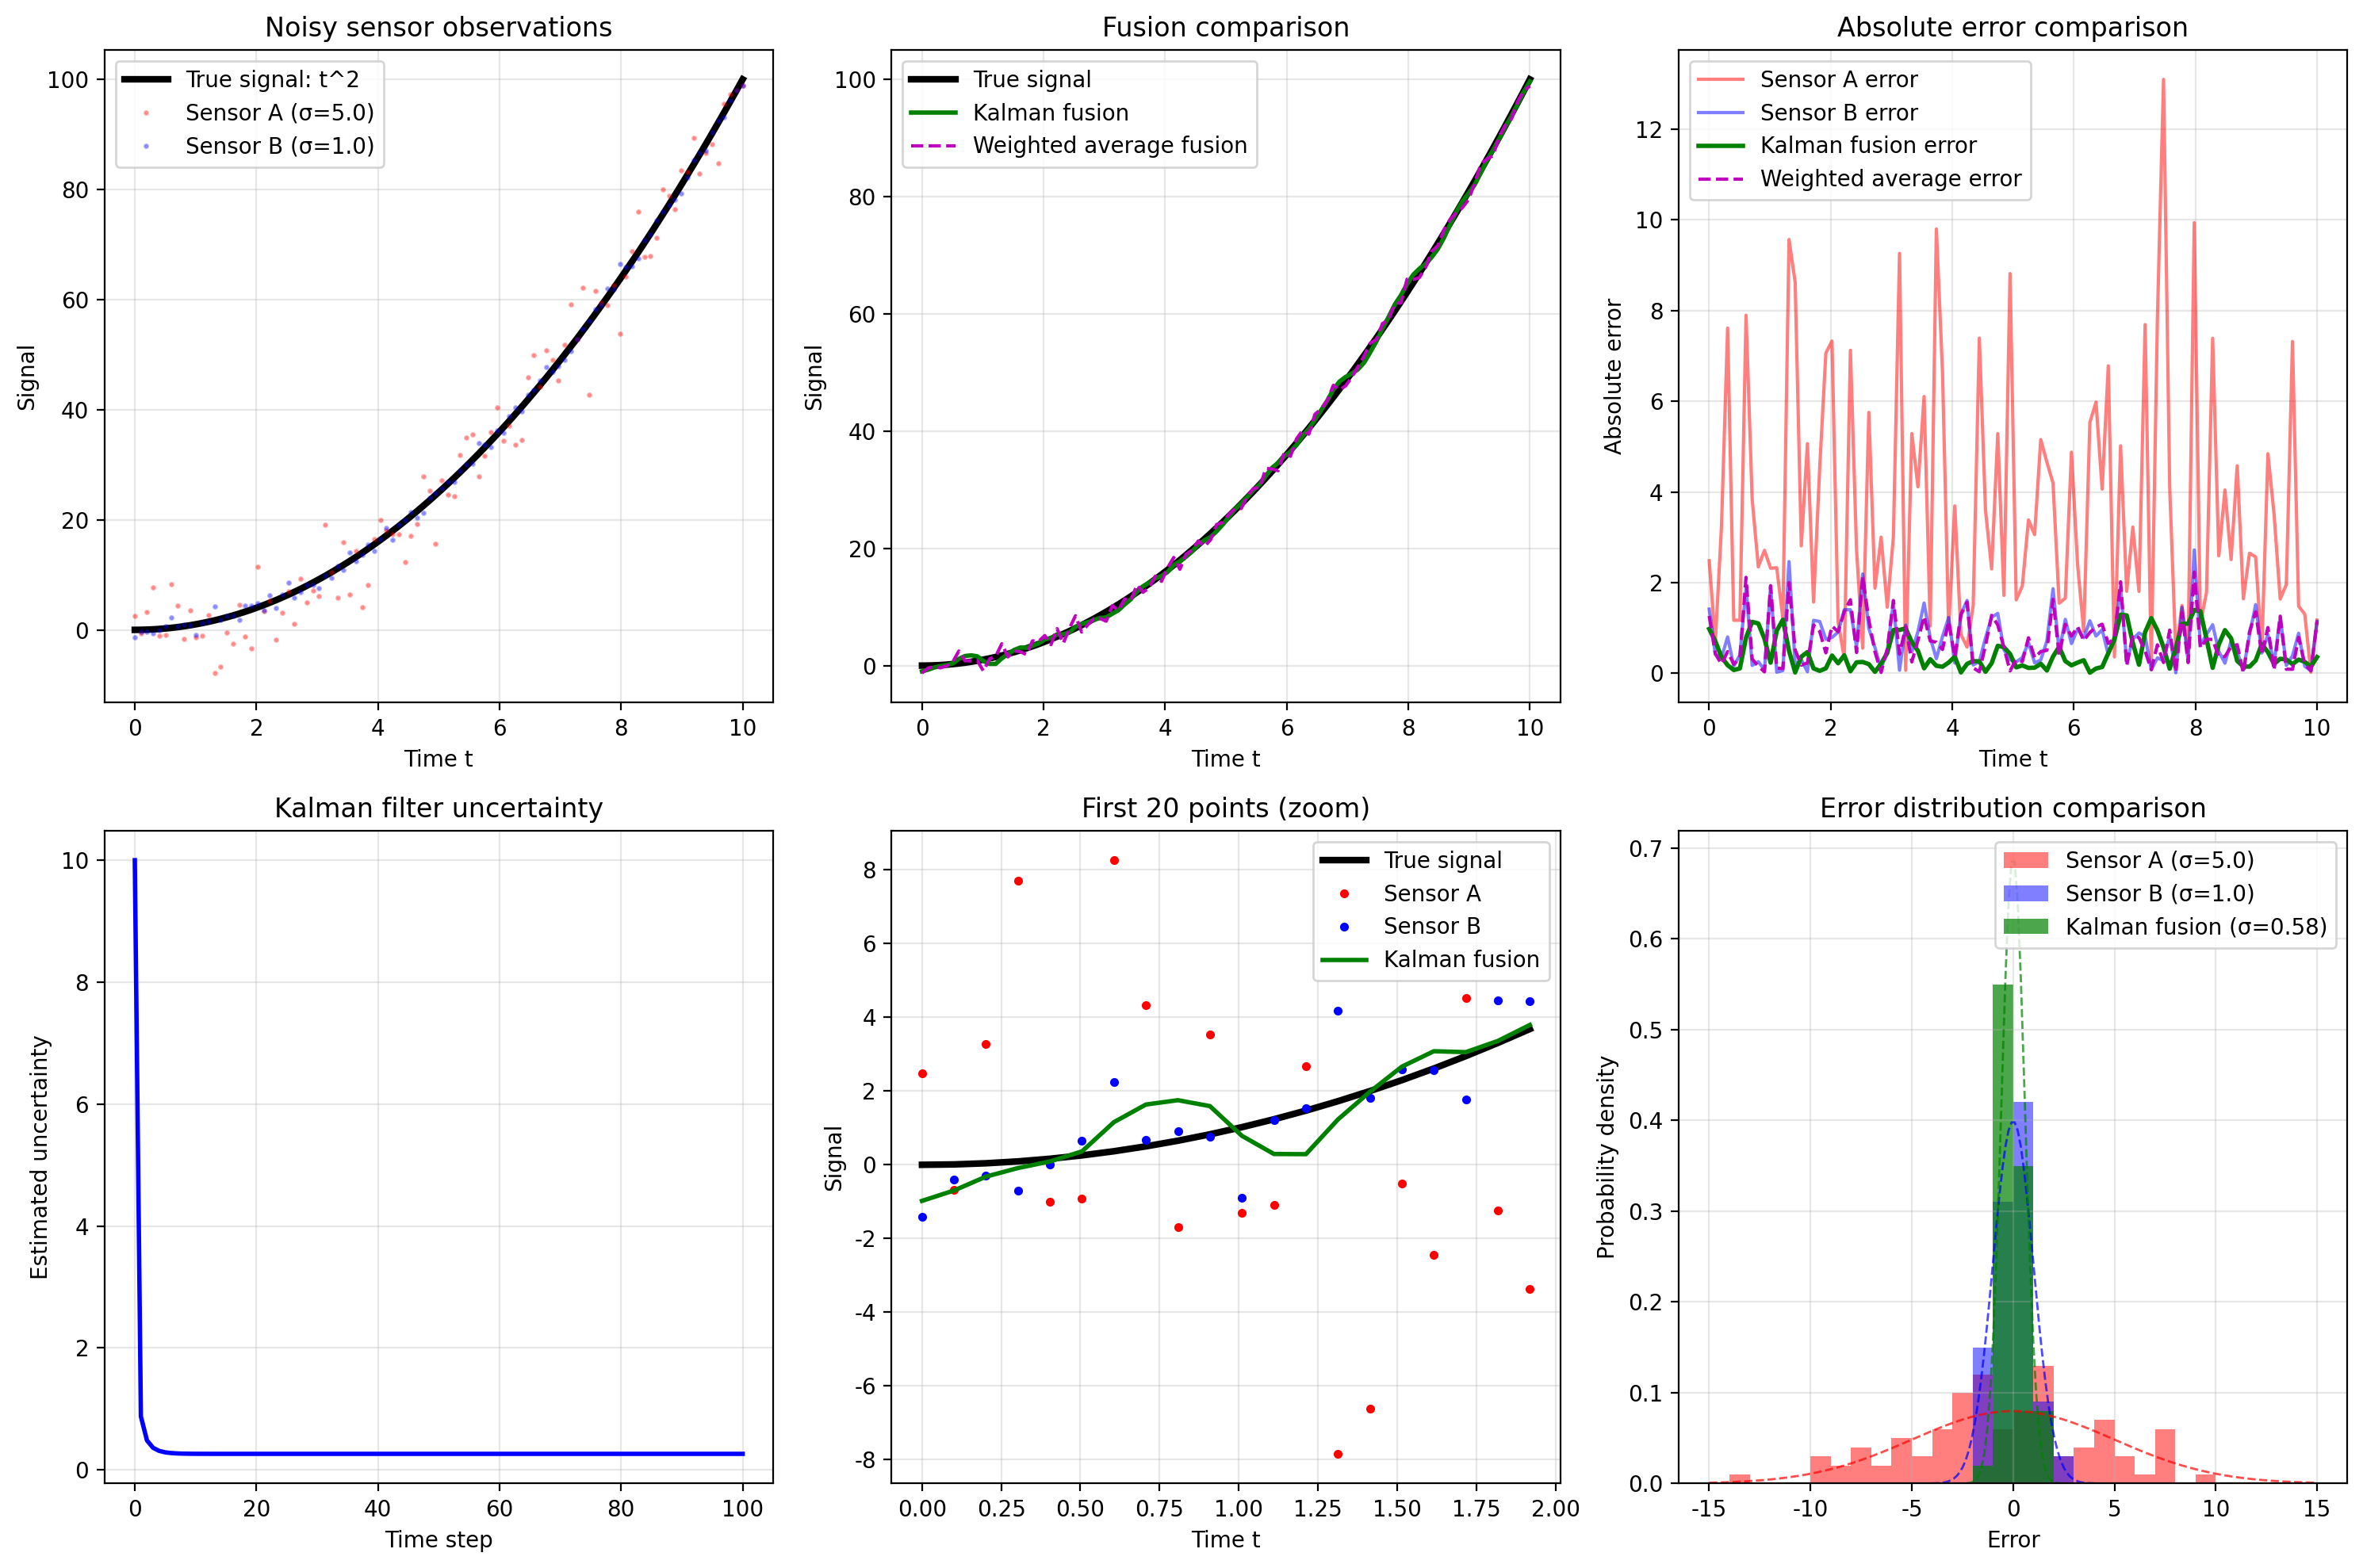


Theoretical analysis:
Sensor A variance: 25.00
Sensor B variance: 1.00
Theoretical optimal fusion variance: 0.9615
Theoretical optimal fusion std: 0.9806
Actual Kalman fusion variance: 0.3334
Actual weighted average variance: 0.8194

Dynamic weight analysis (first 5 points):
time | true | sensor A | sensor B | Kalman estimate | Kalman uncertainty
--------------------------------------------------------------------------------
 0.0 |    0.00 |     2.48 |    -1.42 |       -0.98 |          0.8772
 0.1 |    0.01 |    -0.68 |    -0.41 |       -0.70 |          0.4847
 0.2 |    0.04 |     3.28 |    -0.30 |       -0.32 |          0.3636
 0.3 |    0.09 |     7.71 |    -0.71 |       -0.09 |          0.3128
 0.4 |    0.16 |    -1.01 |     0.00 |        0.09 |          0.2888


In [16]:
def example2_sensor_fusion():
    """Example 2: sensor fusion"""
    np.random.seed(42)
    
    # Parameter setup
    n_points = 100
    time_steps = np.linspace(0, 10, n_points)
    
    # True signal: x(t) = t^2
    true_signal = time_steps**2
    
    # Sensor parameters
    sigma_A = 5.0  # Sensor A has large noise
    sigma_B = 1.0  # Sensor B has small noise
    var_A = sigma_A**2
    var_B = sigma_B**2
    
    # Generate noisy sensor data
    noise_A = np.random.randn(n_points) * sigma_A
    noise_B = np.random.randn(n_points) * sigma_B
    
    measurements_A = true_signal + noise_A
    measurements_B = true_signal + noise_B
    
    # Build filter
    # Initial guess: true start is 0, but we deliberately offset it
    initial_state = 2.0  # True initial state is 0
    initial_uncertainty = 10.0
    process_variance = 0.1  # Process noise because the signal changes over time
    
    kf = MultiSensorKalmanFilter(
        initial_state=initial_state,
        initial_uncertainty=initial_uncertainty,
        process_variance=process_variance
    )
    
    # Batch filtering
    filtered_states = kf.batch_filter(
        range(n_points),
        measurements_A,
        measurements_B,
        var_A,
        var_B
    )
    
    # Performance metrics
    mse_A = np.mean((measurements_A - true_signal)**2)
    mse_B = np.mean((measurements_B - true_signal)**2)
    mse_fusion = np.mean((filtered_states - true_signal)**2)
    
    # Theoretical optimal fusion weights
    # Static case optimal weights: w_A = σ_B²/(σ_A²+σ_B²), w_B = σ_A²/(σ_A²+σ_B²)
    w_A_optimal = var_B / (var_A + var_B)
    w_B_optimal = var_A / (var_A + var_B)
    
    # Simple weighted average for comparison
    simple_fusion = w_A_optimal * measurements_A + w_B_optimal * measurements_B
    mse_simple_fusion = np.mean((simple_fusion - true_signal)**2)
    
    print("=" * 70)
    print("Example 2: Sensor fusion (true signal: x(t) = t^2)")
    print("=" * 70)
    print(f"Sensor A noise std: {sigma_A:.1f}, variance: {var_A:.1f}")
    print(f"Sensor B noise std: {sigma_B:.1f}, variance: {var_B:.1f}")
    print("\nMSE comparison:")
    print(f"  Sensor A only: {mse_A:.4f}")
    print(f"  Sensor B only: {mse_B:.4f}")
    print(f"  Weighted average: {mse_simple_fusion:.4f} (weights: A={w_A_optimal:.3f}, B={w_B_optimal:.3f})")
    print(f"  Kalman fusion: {mse_fusion:.4f}")
    print(f"\nImprovement vs sensor A: {(mse_A - mse_fusion)/mse_A*100:.1f}%")
    print(f"Improvement vs sensor B: {(mse_B - mse_fusion)/mse_B*100:.1f}%")
    print(f"Improvement vs weighted average: {(mse_simple_fusion - mse_fusion)/mse_simple_fusion*100:.1f}%")
    
    # Visualization
    plt.figure(figsize=(15, 10))
    
    # Subplot 1: signals
    plt.subplot(2, 3, 1)
    plt.plot(time_steps, true_signal, 'k-', linewidth=3, label='True signal: t^2')
    plt.plot(time_steps, measurements_A, 'r.', alpha=0.3, markersize=3, label=f'Sensor A (σ={sigma_A})')
    plt.plot(time_steps, measurements_B, 'b.', alpha=0.3, markersize=3, label=f'Sensor B (σ={sigma_B})')
    plt.xlabel('Time t')
    plt.ylabel('Signal')
    plt.title('Noisy sensor observations')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Subplot 2: fusion results
    plt.subplot(2, 3, 2)
    plt.plot(time_steps, true_signal, 'k-', linewidth=3, label='True signal')
    plt.plot(time_steps, filtered_states, 'g-', linewidth=2, label='Kalman fusion')
    plt.plot(time_steps, simple_fusion, 'm--', linewidth=1.5, label='Weighted average fusion')
    plt.xlabel('Time t')
    plt.ylabel('Signal')
    plt.title('Fusion comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Subplot 3: error over time
    plt.subplot(2, 3, 3)
    error_A = np.abs(measurements_A - true_signal)
    error_B = np.abs(measurements_B - true_signal)
    error_fusion = np.abs(filtered_states - true_signal)
    error_simple = np.abs(simple_fusion - true_signal)
    
    plt.plot(time_steps, error_A, 'r-', alpha=0.5, label='Sensor A error')
    plt.plot(time_steps, error_B, 'b-', alpha=0.5, label='Sensor B error')
    plt.plot(time_steps, error_fusion, 'g-', linewidth=2, label='Kalman fusion error')
    plt.plot(time_steps, error_simple, 'm--', linewidth=1.5, label='Weighted average error')
    plt.xlabel('Time t')
    plt.ylabel('Absolute error')
    plt.title('Absolute error comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Subplot 4: uncertainty convergence
    plt.subplot(2, 3, 4)
    plt.plot(range(len(kf.uncertainties)), kf.uncertainties, 'b-', linewidth=2)
    plt.xlabel('Time step')
    plt.ylabel('Estimated uncertainty')
    plt.title('Kalman filter uncertainty')
    plt.grid(True, alpha=0.3)
    
    # Subplot 5: zoom into first 20 points
    plt.subplot(2, 3, 5)
    n_show = min(20, n_points)
    plt.plot(time_steps[:n_show], true_signal[:n_show], 'k-', linewidth=3, label='True signal')
    plt.plot(time_steps[:n_show], measurements_A[:n_show], 'r.', markersize=6, label='Sensor A')
    plt.plot(time_steps[:n_show], measurements_B[:n_show], 'b.', markersize=6, label='Sensor B')
    plt.plot(time_steps[:n_show], filtered_states[:n_show], 'g-', linewidth=2, label='Kalman fusion')
    plt.xlabel('Time t')
    plt.ylabel('Signal')
    plt.title('First 20 points (zoom)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Subplot 6: error distribution
    plt.subplot(2, 3, 6)
    bins = np.linspace(-15, 15, 31)
    plt.hist(measurements_A - true_signal, bins=bins, alpha=0.5, 
             label=f'Sensor A (σ={sigma_A:.1f})', density=True, color='red')
    plt.hist(measurements_B - true_signal, bins=bins, alpha=0.5, 
             label=f'Sensor B (σ={sigma_B:.1f})', density=True, color='blue')
    plt.hist(filtered_states - true_signal, bins=bins, alpha=0.7, 
             label=f'Kalman fusion (σ={np.std(filtered_states - true_signal):.2f})', density=True, color='green')
    
    # Plot theoretical Gaussian distributions
    x = np.linspace(-15, 15, 200)
    plt.plot(x, stats.norm.pdf(x, 0, sigma_A), 'r--', alpha=0.7, linewidth=1)
    plt.plot(x, stats.norm.pdf(x, 0, sigma_B), 'b--', alpha=0.7, linewidth=1)
    plt.plot(x, stats.norm.pdf(x, 0, np.std(filtered_states - true_signal)), 'g--', alpha=0.7, linewidth=1)
    plt.xlabel('Error')
    plt.ylabel('Probability density')
    plt.title('Error distribution comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print theoretical analysis
    print("\n" + "="*70)
    print("Theoretical analysis:")
    print("="*70)
    
    # Static case optimal variance for two independent observations: σ²_fusion = 1/(1/σ_A² + 1/σ_B²)
    theoretical_optimal_variance = 1/(1/var_A + 1/var_B)
    theoretical_optimal_std = np.sqrt(theoretical_optimal_variance)
    
    print(f"Sensor A variance: {var_A:.2f}")
    print(f"Sensor B variance: {var_B:.2f}")
    print(f"Theoretical optimal fusion variance: {theoretical_optimal_variance:.4f}")
    print(f"Theoretical optimal fusion std: {theoretical_optimal_std:.4f}")
    print(f"Actual Kalman fusion variance: {np.var(filtered_states - true_signal):.4f}")
    print(f"Actual weighted average variance: {np.var(simple_fusion - true_signal):.4f}")
    
    # Dynamic weight analysis
    print("\nDynamic weight analysis (first 5 points):")
    print("time | true | sensor A | sensor B | Kalman estimate | Kalman uncertainty")
    print("-" * 80)
    for i in range(min(5, n_points)):
        print(f"{time_steps[i]:4.1f} | {true_signal[i]:7.2f} | {measurements_A[i]:8.2f} | {measurements_B[i]:8.2f} | {filtered_states[i]:11.2f} | {kf.uncertainties[i+1]:15.4f}")
    
    return true_signal, measurements_A, measurements_B, filtered_states, simple_fusion

true_sig, meas_A, meas_B, fused, simple_fused = example2_sensor_fusion()


---

# Particle Filter Python Exercise